In [1]:
from importlib import reload
import backtest
import order_book
import signal_1
import scipy.odr as odr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [3]:
## End Date
end_dt = "2025-02-10"
## Start date
start_dt = "2020-01-20"
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [4]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [5]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, timespan= "day", from_ = start_dt, 
                                    to_=end_dt,
                                  logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE,from_ = start_dt, 
                                    to_=end_dt, timespan="minute", logDir=DIR, _parallel=True)
    HIGH_LOADED = True


Error decoding json response: Expecting ',' delimiter: line 1 column 4501939 (char 4501938)


## Analysis of first correlation bucket

In [9]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [10]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df[0].items()))
mf_bucket = dict(filter(bucket_mask, mid_df[0].items()))

### Need to find weighting for positions in portfolio

In [44]:
yf_res = yf.Ticker("ACWX")
yf_res.history(interval="1D", period='2y')

ERROR:yfinance:ACWX: No price data found, symbol may be delisted (period=2y)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [54]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
hist = mid_df[0]['ACWI']
# hist = yf_res.history(interval="1D", period='2y').reset_index().rename(columns={'Close':bm_ticker,
#       
hist['timestamp'] = hist['timestamp'].to_datetime()
hist = hist.set_index('timestamp').tz_localize(None)
bm_data = hist[['close']]
bm_data



C:\Users\raymo\AppData\Local\Temp\ipykernel_58384\1586568570.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


AttributeError: 'Series' object has no attribute 'to_datetime'

In [12]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_58384\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7134,"AOA,SDS",-0.950992
7083,"AOA,SPXU",-0.948960
7125,"AOA,SH",-0.948941
7089,"AOA,SPXS",-0.948182
129160,"SPXS,SH",0.993566
128571,"SPXU,SH",0.994723
152083,"SH,SDS",0.997474
129169,"SPXS,SDS",0.997839
128540,"SPXU,SPXS",0.998401
128578,"SPXU,SDS",0.998524


In [13]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present
hf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_58384\2129899211.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 13:32:00,28.070,14.88,315.340
2022-03-30 13:33:00,28.075,14.89,315.000
2022-03-30 13:34:00,28.075,14.89,315.002
2022-03-30 13:35:00,28.110,14.89,314.400
2022-03-30 13:36:00,28.085,14.90,315.000
...,...,...,...
2025-02-10 23:38:00,51.300,26.14,42.050
2025-02-10 23:48:00,51.300,26.14,42.050
2025-02-11 00:01:00,51.270,26.14,42.050


In [14]:
min(hf_df.index)

Timestamp('2022-03-30 13:32:00')

In [15]:
mf_bucket['SVXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,33.750,33.900,32.650,33.225,7778068.0,33.1842,1582174800000,33294,None
1,32.715,32.855,31.740,32.190,8503196.0,32.2007,1582261200000,34567,None
2,29.730,30.615,29.095,29.135,11459590.0,29.8246,1582520400000,41449,None
3,29.790,29.880,27.420,27.815,13483032.0,28.6994,1582606800000,54238,None
4,28.320,28.805,27.650,28.195,12609526.0,28.2848,1582693200000,52757,None
...,...,...,...,...,...,...,...,...,...
1246,50.400,50.990,50.085,50.780,799700.0,50.6620,1738645200000,6539,None
1247,50.710,51.410,50.510,51.340,922519.0,51.0453,1738731600000,7094,None
1248,51.620,51.650,51.070,51.570,869287.0,51.4841,1738818000000,6849,None
1249,51.730,51.800,50.610,50.620,989746.0,51.0742,1738904400000,8385,None


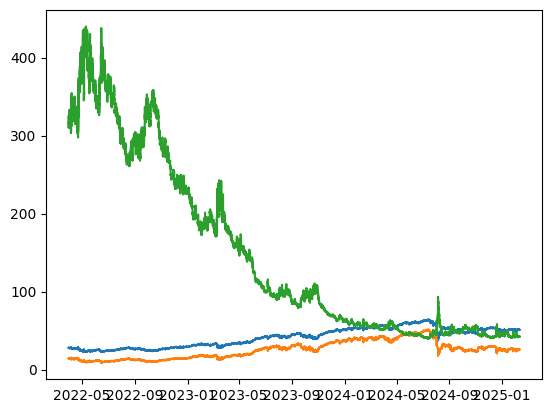

In [16]:
plt.plot(hf_df)

In [17]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
    
def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].mean()
    std = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

,SVXY,SVIX,VIXY
Mu,0.000348,0.000793,-0.002468
Sigma,0.025530,0.042817,0.047519
Beta,-0.000241,-0.000147,0.000504
Mu_Min,0.000029,0.000076,-0.000194
Sigma_Min,0.047491,0.087446,0.089843


In [24]:
hf_bucket['VIXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,894.40,894.40,894.40,894.40,3.75,894.4000,1582190580000,2,None
1,894.40,894.40,894.40,894.40,1.25,894.4000,1582191000000,1,None
2,894.40,894.40,894.40,894.40,1.25,894.4000,1582191120000,1,None
3,900.00,900.00,899.20,899.20,26.75,899.2640,1582200000000,10,None
4,900.00,900.00,900.00,900.00,3.75,900.0000,1582200600000,1,None
...,...,...,...,...,...,...,...,...,...
596317,42.18,42.19,42.18,42.19,350.00,42.1764,1739233680000,4,None
596318,42.18,42.18,42.18,42.18,100.00,42.1800,1739233800000,1,None
596319,42.18,42.18,42.18,42.18,300.00,42.1800,1739233920000,3,None
596320,42.18,42.18,42.18,42.18,252.00,42.1800,1739234820000,5,None


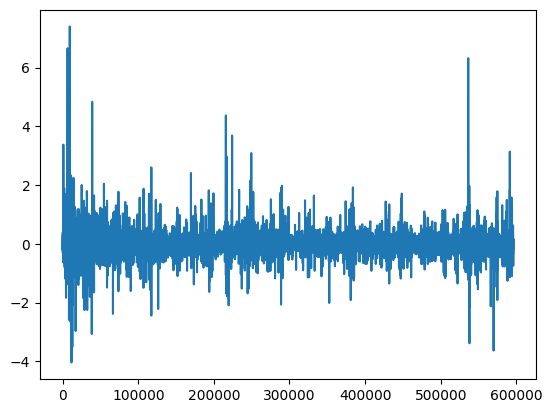

In [25]:
plt.plot(logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'])

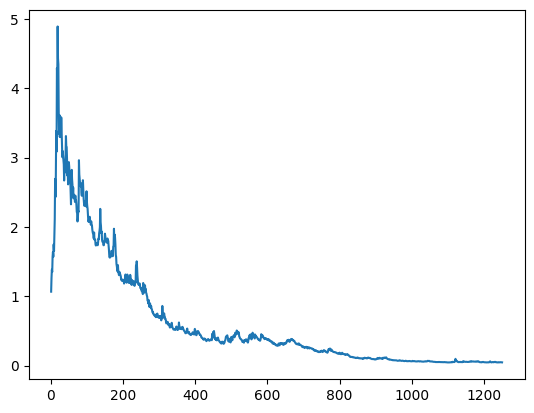

In [26]:
original = np.exp(logReturnTransform(mf_bucket['VIXY'].drop('otc',axis=1))['close'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [27]:
hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [28]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [29]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [35]:
bm_data

,^FTW5000


In [34]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
hf_log = logReturnTransform(hf_df)
hf_log = pd.merge_asof(hf_log, logReturnTransform(bm_data.drop('otc',axis=1)), on = 'timestamp').dropna().set_index('timestamp')
components = list(hf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
hf_log[components] = hf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *hf_log[bm_ticker] , axis = 0)
hf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = 'VIXY' #hf_df.columns[0]
x_temp = hf_log.loc[:, ~hf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(hf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

KeyError: "['otc'] not found in axis"

In [40]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

reference_ticker = "VIXY"
elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(-1*hf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(hf_df[reference_ticker])
print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

NameError: name 'coeffs_' is not defined

In [31]:
reload(DataExtensions)
outlier_idxs = DataExtensions.zscoreOutliers(signal.pct_change(), params={'std':6})
## these are looking for stock splits 
win1 = outlier_idxs[0]
hf_df[win1[0] - pd.Timedelta(days=2):win1[1]+ pd.Timedelta(days=2)]

,SVXY,SVIX,VIXY
timestamp,,,
2023-01-04 13:49:00,29.600,14.88,224.2
2023-01-04 13:50:00,29.600,14.88,224.2
2023-01-04 13:51:00,29.595,14.88,224.0
2023-01-04 13:55:00,29.590,14.88,224.0
2023-01-04 14:00:00,29.555,14.88,224.8
...,...,...,...
2023-01-06 21:24:00,30.145,15.41,216.4
2023-01-06 21:29:00,30.140,15.41,216.4
2023-01-06 21:34:00,30.155,15.41,216.4


In [32]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2023-01-03 12:24:00,-190.519602
2023-01-03 12:25:00,-190.519602
2023-01-03 12:31:00,-190.507978
2023-01-03 13:00:00,-190.519602
2023-01-03 13:02:00,-190.507978
...,...
2023-06-13 20:10:00,-66.216812
2023-06-13 20:27:00,-66.163970
2023-06-13 20:30:00,-66.158098


In [33]:
Signal

,Signal
timestamp,
2023-01-03 12:24:00,-190.519602
2023-01-03 12:25:00,-190.519602
2023-01-03 12:31:00,-190.507978
2023-01-03 13:00:00,-190.519602
2023-01-03 13:02:00,-190.507978
...,...
2023-06-13 20:10:00,-66.216812
2023-06-13 20:27:00,-66.163970
2023-06-13 20:30:00,-66.158098


In [34]:
reference_ticker

'VIXY'

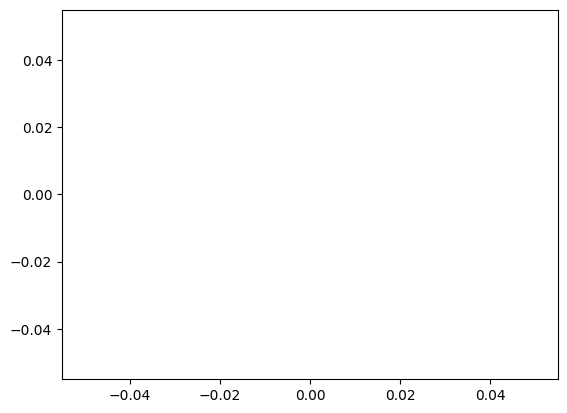

In [36]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker])))

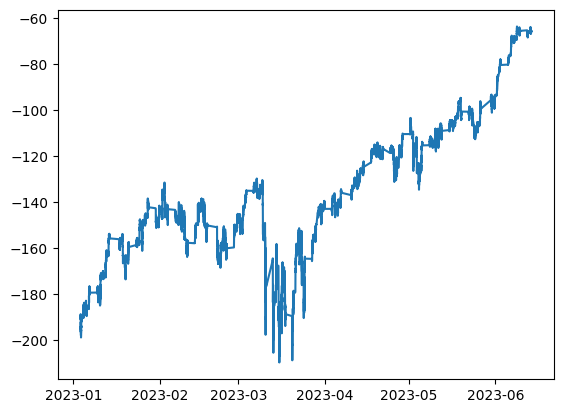

In [37]:
plt.plot(Signal)

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Text(0, 0.5, 'Value')

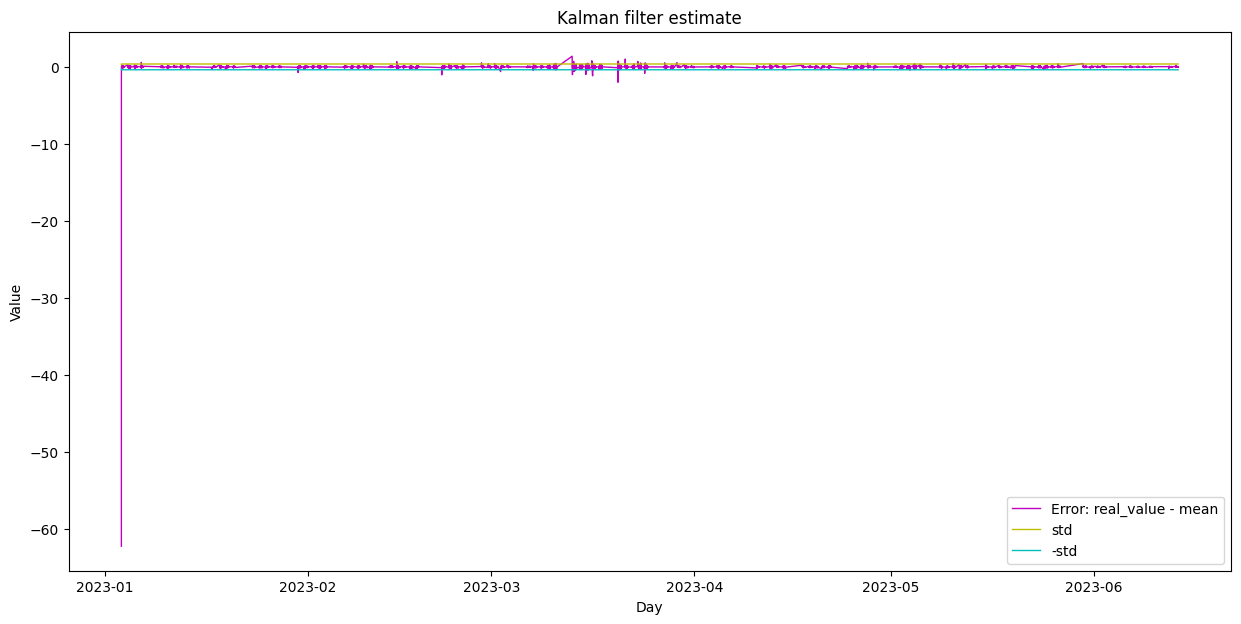

In [59]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'VIXY']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     np.mean(Signal[-252:]),
                                                     np.var(Signal[-252:]))
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, - np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

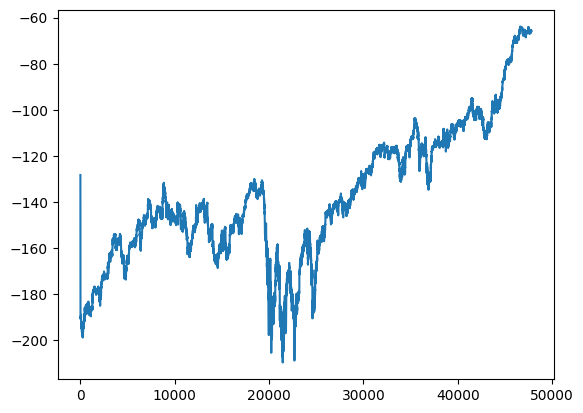

In [60]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
state_means, state_covs =means, covs 
plt.plot(state_means)#, state_covs
# DataExtensions.draw_slope_intercept_changes(Signal, state_means)

[-128.28067267 -182.51753079 -189.52746897 ...  -66.15958559  -65.80568677
  -65.77774615]


Text(0, 0.5, 'Residuals')

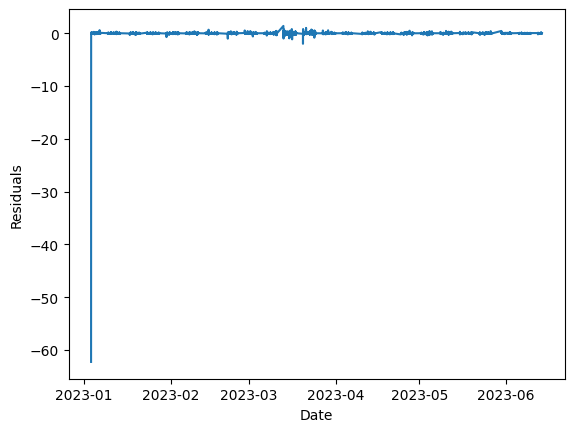

In [61]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [62]:
means

array([[-128.28067267],
       [-182.51753079],
       [-189.52746897],
       ...,
       [ -66.15958559],
       [ -65.80568677],
       [ -65.77774615]])

In [63]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

optimal solution cost 0.0 found
solution:


In [64]:
raw = raw.reset_index().set_index('timestamp')
raw

,0,VIXY
timestamp,,
2023-01-03 12:24:00,35.480398,226.000
2023-01-03 12:25:00,35.480398,226.000
2023-01-03 12:31:00,35.492022,226.000
2023-01-03 13:00:00,35.480398,226.000
2023-01-03 13:02:00,35.492022,226.000
...,...,...
2023-06-13 20:10:00,47.783188,114.000
2023-06-13 20:27:00,47.836030,114.000
2023-06-13 20:30:00,47.841902,114.000


In [65]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (0 and VIXY) is cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_43296\246132147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [66]:
np.array(means).squeeze()

array([-128.28067267, -182.51753079, -189.52746897, ...,  -66.15958559,
        -65.80568677,  -65.77774615])

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


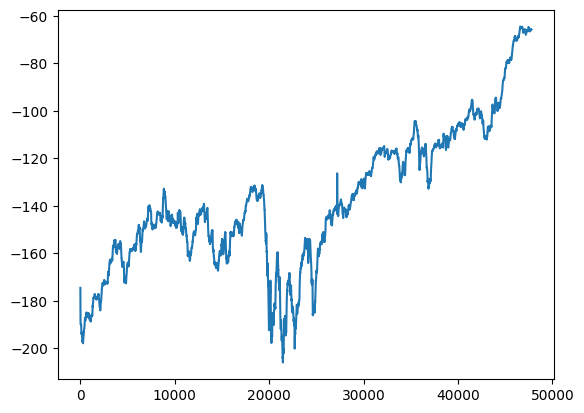

In [67]:
### roll filter over 90 day windows
roll = 0
training_period = datetime.timedelta(days=90)
min_time_delta = datetime.timedelta(hours=1)
start_date = Signal.index[0]
means = []
covs = []
while (start_date + training_period < Signal.index[-1]):
    means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
                Signal[start_date:start_date+training_period], 
                np.mean(Signal[start_date:start_date+training_period]),
                np.var(Signal[start_date:start_date+training_period]))
    means.extend(means_temp)
    covs.extend(covs_temp)
    # print(len(Signal[start_date:start_date+training_period]),len(covs))
    # print()
    start_date += (training_period + min_time_delta)
means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
            Signal[start_date:], 
            np.mean(Signal[start_date:]),
            np.var(Signal[start_date:]))
means.extend(means_temp)
covs.extend(covs_temp)
# print(len(Signal[start_date:]), len(covs))
plt.plot(means)

In [68]:
state_means0 = np.array(pd.DataFrame(means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

[-174.49668316 -179.86422853 -182.55736078 ...  -65.87618881  -65.8702731
  -65.86551775]


ValueError: operands could not be broadcast together with shapes (47796,) (47769,) 

ValueError: x and y must have same first dimension, but have shapes (47796,) and (47769,)

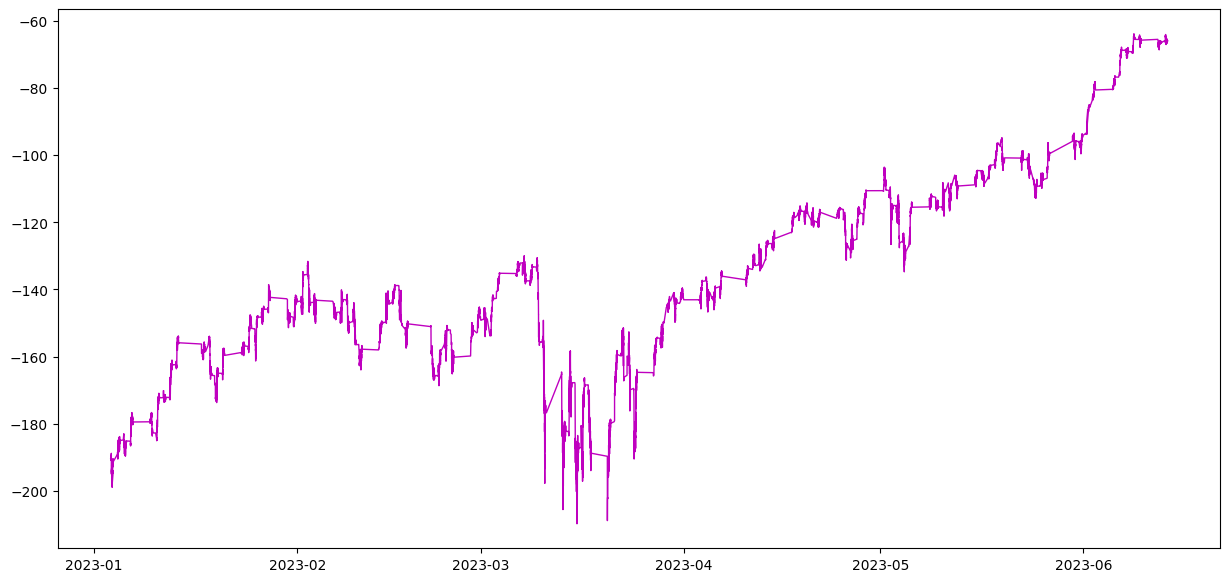

In [69]:
# mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'], 'm', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() + 2*np.sqrt(covs).squeeze(), 'y', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() - 2*np.sqrt(covs).squeeze(), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

In [58]:
df = pd.DataFrame()
df['primitive_signal'] = Signal['Signal']
df = df.merge(hf_df, on='timestamp', how='left')
df['filter_resid'] = resid
df['filter_spread'] = stdev

def simpleFilterSignal(dr, epsilon):
    if dr.filter_resid < -dr.filter_spread*epsilon:
        return -1
    elif dr.filter_resid > dr.filter_spread*epsilon:
        return 1
    else:
        return 0

means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     np.mean(Signal[-252:]),
                                                     np.var(Signal[-252:]))

df['Signal'] = df.apply(lambda dr: simpleFilterSignal(dr, 2), axis=1)
df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
df = df.reset_index().rename(columns={"timestamp":"Date"})
df

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Date,primitive_signal,SVXY,SVIX,VIXY,filter_resid,filter_spread,Signal,BuySell
0,2023-01-03 12:24:00,-190.519602,29.485,14.780,226.000,-62.238929,0.282215,-1,NaN
1,2023-01-03 12:25:00,-190.519602,29.485,14.780,226.000,-8.002071,0.372572,-1,0.0
2,2023-01-03 12:31:00,-190.507978,29.495,14.780,226.000,-0.980509,0.373823,-1,0.0
3,2023-01-03 13:00:00,-190.519602,29.485,14.780,226.000,-0.121657,0.373842,0,1.0
4,2023-01-03 13:02:00,-190.507978,29.495,14.780,226.000,-0.013492,0.373842,0,0.0
...,...,...,...,...,...,...,...,...,...
47791,2023-06-13 20:10:00,-66.216812,39.655,24.769,114.000,-0.001802,0.373842,0,0.0
47792,2023-06-13 20:27:00,-66.163970,39.700,24.769,114.000,0.006259,0.373842,0,0.0
47793,2023-06-13 20:30:00,-66.158098,39.705,24.769,114.000,0.001487,0.373842,0,0.0
47794,2023-06-13 20:34:00,-65.756227,39.710,24.769,113.604,0.049460,0.373842,0,0.0


In [122]:
BBO = order_book.Book()
HOLDING_PERIOD_CHECK = {}
isLong = False
hasPosition = False

def isFirstTrade(ticker, date):
    if ticker not in HOLDING_PERIOD_CHECK:
        return True
    if date not in HOLDING_PERIOD_CHECK[ticker]:
        return True
    return False

for row in df.itertuples():
    if (row.BuySell == 1 
        and not hasPosition
        and isFirstTrade("SVIX", row.Date.normalize())):
        print('bought spread at ', row.Date)
        BBO.addOrder(row.Date, "SVIX", row.SVIX, -10)
        BBO.addOrder(row.Date, "VIXY", row.VIXY, 10)
        if "SVIX" not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK["SVIX"] = []
        HOLDING_PERIOD_CHECK['SVIX'].append(row.Date.normalize())
        isLong = True
        hasPosition = True
    elif (row.BuySell == -1 
        and not hasPosition
        and isFirstTrade("SVIX", row.Date.normalize())):
        print('sold spread at ', row.Date)
        BBO.addOrder(row.Date, "SVIX", row.SVIX, 10)
        BBO.addOrder(row.Date, "VIXY", row.VIXY, -10)
        isLong = False
        if "SVIX" not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK["SVIX"] = []
        HOLDING_PERIOD_CHECK['SVIX'].append(row.Date.normalize())
        hasPosition = True
        isLong = False
    else:
        if hasPosition and isFirstTrade("SVIX", row.Date.normalize()):
            print('exit spread at ', row.Date)
            BBO.addOrder(row.Date, "SVIX", row.SVIX,-10 * (2* int(isLong) - 1))
            BBO.addOrder(row.Date, "VIXY", row.VIXY, 10 * (2 * int(isLong) - 1))
            if "SVIX" not in HOLDING_PERIOD_CHECK:
                HOLDING_PERIOD_CHECK["SVIX"] = []
                HOLDING_PERIOD_CHECK['SVIX'].append(row.Date.normalize())
            hasPosition = False
            isLong = False

#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

sold spread at  2022-03-30 18:00:00
exit spread at  2022-03-31 08:00:00
sold spread at  2022-03-31 19:00:00
exit spread at  2022-04-01 08:00:00
sold spread at  2022-04-01 15:00:00
exit spread at  2022-04-04 09:00:00
sold spread at  2022-04-04 12:00:00
exit spread at  2022-04-05 08:00:00
sold spread at  2022-04-05 14:00:00
exit spread at  2022-04-06 08:00:00
bought spread at  2022-04-07 18:00:00
exit spread at  2022-04-08 08:00:00
sold spread at  2022-04-08 13:00:00
exit spread at  2022-04-11 08:00:00
bought spread at  2022-04-11 09:00:00
exit spread at  2022-04-12 08:00:00
bought spread at  2022-04-12 12:00:00
exit spread at  2022-04-13 08:00:00
bought spread at  2022-04-13 15:00:00
exit spread at  2022-04-14 09:00:00
sold spread at  2022-04-14 18:00:00
exit spread at  2022-04-18 08:00:00
bought spread at  2022-04-18 12:00:00
exit spread at  2022-04-19 08:00:00
sold spread at  2022-04-19 12:00:00
exit spread at  2022-04-20 08:00:00
sold spread at  2022-04-21 16:00:00
exit spread at  20

In [123]:
BBO.getOrderDf()

,Date,Ticker,Price,Quantity,Longshort
0,2022-03-30 18:00:00,SVIX,14.63,10,True
1,2022-03-30 18:00:00,VIXY,321.40,-10,False
2,2022-03-31 08:00:00,SVIX,14.80,10,True
3,2022-03-31 08:00:00,VIXY,317.40,-10,False
4,2022-03-31 19:00:00,SVIX,14.07,10,True
...,...,...,...,...,...
1347,2024-11-21 00:00:00,VIXY,47.70,-10,False
1348,2024-11-25 09:00:00,SVIX,28.10,-10,False
1349,2024-11-25 09:00:00,VIXY,43.89,10,True
1350,2024-11-26 00:00:00,SVIX,28.07,-10,False


In [124]:

df1 = df[['Date', 'SVIX']]
df2 = df[['Date', 'VIXY']]
df1['Ticker'] = 'SVIX'
df2['Ticker'] = 'VIXY'

df_res = pd.concat([df1.rename(columns={'SVIX':'Price'}),df2.rename(columns={'VIXY':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
BBO.backfillPnL(df_res)

C:\Users\raymo\AppData\Local\Temp\ipykernel_22220\2903296011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Ticker'] = 'SVIX'
C:\Users\raymo\AppData\Local\Temp\ipykernel_22220\2903296011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ticker'] = 'VIXY'


                    Date  Price Ticker
0    2022-03-30 13:00:00  15.06   SVIX
1    2022-03-30 14:00:00  14.80   SVIX
2    2022-03-30 15:00:00  14.67   SVIX
3    2022-03-30 16:00:00  14.79   SVIX
4    2022-03-30 17:00:00  14.84   SVIX
...                  ...    ...    ...
9209 2024-12-10 19:00:00  41.60   VIXY
9210 2024-12-10 20:00:00  41.85   VIXY
9211 2024-12-10 21:00:00  41.76   VIXY
9212 2024-12-10 22:00:00  41.96   VIXY
9213 2024-12-11 00:00:00  41.96   VIXY

[18428 rows x 3 columns]


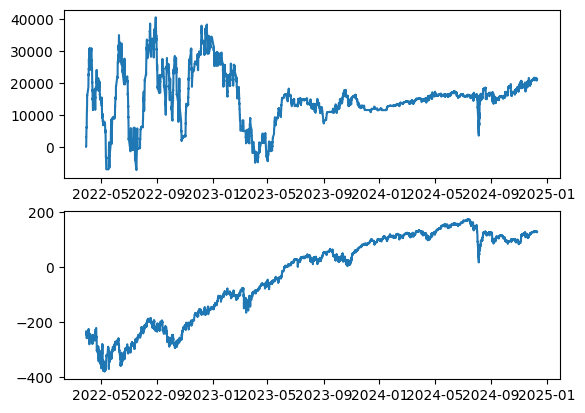

In [125]:
hist = BBO.getHistoryDf()
figure, axis = plt.subplots(2,1)

# For Sine Function
axis[0].plot(hist.index, hist['PnL'])
# axis[0, 0].set_title("Sine Function")

# For Cosine Function
axis[1].plot(Signal.index, Signal)
# axis[0, 1].set_title("Cosine Function")
# plt.plot(hist['PnL'])
plt.show()

In [ ]:
hist